# Time Series Analysis

November, 20, 2017

Lecture #18

Souces: Ivezic Textbook, AstroML online code, University of Washington online lectures https://github.com/uw-astr-324-s17/astr-324-s17

# Preparations

- make sure that pymc is installed:   
   `conda install pymc`



- install these two packages  
`pip install gatspy  
pip install supersmoother`

In [14]:
#some imports 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import stats
from astroML.datasets import fetch_rrlyrae_templates
from astroML.fourier import\
    FT_continuous, IFT_continuous, sinegauss, sinegauss_FT, wavelet_PSD
import astroML.datasets.rrlyrae_templates
astroML.datasets.rrlyrae_templates.DATA_URL = ("http://www2.mpia-hd.mpg.de/~bsesar/S82_RRLyr/RRLyr_ugriz_templates.tar.gz")
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap



bubble_size=50

#big plots for presentation; comment all out for normal use
#plt.style.use('seaborn-talk')
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.color'] = 'r'
bubble_size=150

# Main Concepts for Time Series Analysis

Time series analysis discussed today will be limited to two-dimensional scalar data sets $(t_1,y_1), \ldots,(t_N,y_N).$  In many ways,  the analysis will be similar to the parameter estimation and model selection problems we previously learned about in chapter 8, except that we replace $x$ with $t$.  There are some important differences encountered in time series analysis, such as
- these models that have a sense of the directionality of time in them 
- while it was previously assumed that the $y$-values are independent,  for time series, $y_{i+1}$ is likely to depend directly on $y_i$
- these models make no assumptions about the regularity of sampling  


There is a broad range of variability signatures that we want to be aware of, from transient events to periodic variables, to stochastic sources.  

<img src="ts_imgs/flare.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="ts_imgs/cepheid.png" style="float: left; width: 30%; margin-right: 1%;"> <img src="ts_imgs/eclipsing.png" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

When dealing with time series data, the first thing that we want to know is if the system that we are studying is even variable - otherwise there is no point in doing the time-series analysis.  In the context of frequentist statistics, this is a question of whether our data would have been obtained by chance if the no-variability null hypothesis were correct.  

If we find that our source _is_ variable, then our time-series analysis has two main tasks:
1. To characterize the presumed temporal correlation between different values of $y$, including its significance
2. To preduct future values of $y$

In many astronomical cases, the key goal is to characterize the underlying physical processes that produced the data, typically by learning the parameters for a model.  

## Is My Time Series Just Noise?

Determining whether variability has been detected in a time series, regardless of of the details of the underlying process, is equivalent to asking whether the data are consistent with the null hypothesis described by a model consisting of a constant signal plus measurement noise.  

So, from the viewpoint of classical (frequentist) statistics, this question can be treated as a case of hypothesis testing: What is the probability that we would obtain our data by chance if the null hypothesis of null variability were correct?

If the errors are known and Gaussian, we an simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal.  If the errors are unknown, or non-Gaussian, the modeling and model selection tools, such as those introduced in chapter 5 for treating exponential noise or outliers, can be used instead.

### Example case

Consider a simple example of a sinusoidal variable signal $Y(t) = A \sin(\omega t)$ sampled by $N \sim 100$ data points with Gaussian errors with standard deviation $\sigma$.  The variance of this model is $V = \sigma^2 + A^2 / 2$.

If $A=0$ (no variability)
- $\chi^2_{dof} = \frac{1}{N}\sum_j ( \frac{y_j}{\sigma} )^2 \sim V/\sigma^2$ 
- $\chi^2_{dof}$ has expectation value of 1 and std dev of $\sqrt{ \frac{2}{N}} $


If $|A| > 0$ (variability)
- $\chi^2_{dof}$ will be larger than 1.
- the probability that $\chi^2_{dof} > 1 + 3 \sqrt{2/N}$ is about 1 in 1000 (i.e., $>3\sigma$ above 1)

If this false-positive rate is acceptable then the minimum detectable amplitude is:
$$ A > ( \frac{72}{N})^{1/4} \sigma \sim 2.9 \sigma N^{-1/4}$$
which follows from equating $V/\sigma^2 = 1+3\sqrt{2/N}$, expanding $V$, and solving for $A$.

For $N=100$ data points, the minimum detectable amplitude is $A = 0.92\sigma$.

For $N=1000, A=0.52\sigma$.

However, we will see that in all cases of specific models, our ability to discover variability is greatly improved compared to this simple $\chi^2_{dof}$ selecction.  If we have enough data points, we can actually detect variability whose amplitude is smaller than the uncertainty in the  measurements.  

Note that for this example, this is the best that we can do under the assumption of the null hypothesis of no variability.  If instead we know the model (not limited to periodic variability), then we can perform a matched filter analysis and improve upon this to positively identify lower-amplitude variability.

This improvement to detect a signal using a model is not limited to periodic variability.  If the undelrying variability is not periodic, it can be roughly divided into two other families: stochastic variability (where variability is always there but the changes are not preditable for an indefinite period) and temporally localized events (such as bursts).  

# Modeling Toolkit for Time Series Analysis

The main tools for time series analysis belong either to the time domain or the frequency domain.  Many of the tools and methods discussed in earlier chapters play a prominent roll in the analysis of time series data.

## Parameter Estimation, Model Selection, and Classification

The detection of a signal, whatever it may be, is essentially a hypothesis testing or model selection problem.  The quantitative description of a signal belongs to parameter estimation and regression problems.  

In general, we will fit a model to a set of $N$ data points $(t_j, y_j),\   j=1,\ldots,N$ with known errors for $y$,
$$ y_j(t_j) = \sum^M_{m=1} \beta_m T_m (t_j | \theta_m) + \epsilon_j,$$
where the functions $T_m (t_j | \theta_m)$ need not be periodic, nor do the times $t_j$ need to be evenly sampled.  As before, the vector $\theta_m$ contains model parameters that describe each $T_m$. The symbol  $\epsilon$ stands for noise, which is typically described by heterscedastic Gaussian errors with zero mean and parameterized by known $\sigma_j$. 

Common deterministic models for underlying process include
- $T(t) = \sin(\omega t)$
- $T(t) = \exp(- \alpha t)$
- $T(t) = \sin(\phi + \omega t + \alpha t^2)$ aka "chirp signal"

In these equations, frequency $\omega$ and decay rate $\alpha$ are parameters to be estimated from the data.  Finding wheter data favor such a model over the simplest possibility of no  variability is no different from model selection problems discussed earlier, and can be addressed via the Bayesian model odds ratio.  Given a quantitative description of time series $y(t)$, the best-fit estimates of model parameters $\theta_m$ can then be used as attributes for various supervised and unsupervised classification methods.

## Fourier Analysis

In Fourier analysis, general trigonometric functions are represented or approximated by integrals or sums of simpler trigonometric functions.  The more terms that are included in the sum, the better the resulting approximation.  For periodic functions, such as periodic light curves in astronomy, it is often true that a relatively small number of terms ($<10$) suffices to reach an approximation precision level similar to the measurement precision.

When the data are evenly sampled and the signal-to-noise ratio is high, Fourier analysis can be a powerful tool.  When the noise is high compared to the signal, or the signal has a complex shape, a probabilistic treatment offers substantial improvements.  And for unevenly sampled data or data with heteroscedastic errors, probabilistic treatment becomes essential. For these reasons, in the analysis of astronomical time series, Fourier analysis is often replaced by other methods.  Nevertheless, most of the main concepts introduced in Fourier analysis carry over to those other methods and thus Fourier analysis is an indispensable tool when analyzing time series.


The code below demonstrates a common application: reconstruction of a complicated signal by summation of simpler trig functions.  

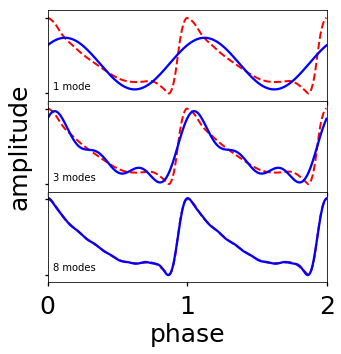

In [3]:
# Ivezic, Figure 10.1
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    # reconstruct using k frequencies
    y_fft = np.fft.fft(y) # compute FFT
    y_fft[k + 1:-k] = 0 # zero-out frequencies higher than k
    y_fit = np.fft.ifft(y_fft).real # reconstruct using k modes

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2, color='red')
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='blue')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

For a quick review, the Fourier transform of function $h(t)$ is defined as 
$$ H(f) = \int_{-\infty}^{\infty} h(t) \exp(-i2\pi ft) dt,$$
with inverse transformation
$$ h(t) = \int_{-\infty}^{\infty} H(f) \exp(i 2\pi ft) df,$$
where $t$ is time and $f$ is frequency.  



An important quantity in time series analysis is the one-sided power spectral density (PSD) function defined for $0 \leq f < \infty$ as 

$$\text{PSD}(f) \equiv |H(f)|^2 + |H(-f)|^2. $$

The PSD gives the amount of power contained in the frequency interval between $f$ and $f+df$. 

Parseval's theorem states that the total power is the same whether computed in the frequency or the time domain:

$$P_{tot} \equiv \int_0^\infty \text{PSD}(f) df = \int_{-\infty}^{\infty}|h(t)|^2 dt.$$

### Convolution Theorem

Convolution is a mathematical operation on two functions that gives the integral of the pointwise multiplication of the two functions as a function of the amount that one of the original functions is translated.  The convolution of two functions $a(t)$ and $b(t)$ is given by

$$ [a \star b](t) \equiv \int_{-\infty}^\infty a(t')b(t-t')dt'.$$

Convolution is an unavoidable result of the measurement process because the measurement resolution, whether in time, spectral, spatial, or any other domain, is never infinite.  In the above equation $a$ can be thought of as the "convolving pattern" of the measuring apparatus, and the function $b$ is the signal.  In practice, we measure the convolved (or smoothed) version of our signal $[a \star b](t)$, and seek to uncover the original signal $b$ using the presumably known $a$.

The **convolution theorem** states that if $h = a \star b$, then the Fourier transforms of $h$, $a$, and $b$ are related by their pointwise products:

$$H(f) = A(f)B(f).$$

Thus a convolution of two functions is transformed into a simple multiplication of the associated Fourier representations.  Therefore, to obtain $b$, we can simply take the inverse Fourier transform of the ration $H(f)/A(f)$.  In the absense of noise, this operation is exact.

Visual example of convolution:

<img src="ts_imgs/convolution.png" style="width: 70%;">

## Discrete Fourier Transform


When computing the Fourier transform for discretely and uniformly sampled data, the Fourier integrals from the previous section are translated into sums.  Let us assume that we have a continuous real function $h(t)$ which is sampled at $N$ equal intervals $h_j = h(t_j)$ with $t_j \equiv t_0 + j\Delta t, \  t=0, \ldots,(N-1)$, where the sampling interval $\Delta t$ and the duration of the data taking $T$ are related via $T=N\Delta t$. 

The discrete Fourier transform of values $h_j$ is a complex vector of length $N$ defined by

$$ H_k = \sum_{j=0}^{N-1} h_j \exp[-i 2\pi jk/N],$$

where $k=0,\ldots,(N-1)$.  The corresponding inverse discrete Fourier transform is defined by

$$ h_j = \frac{1}{N} \sum_{j=0}^{N-1} H_k \exp[i 2\pi jk/N],$$

where $j=0,\ldots,(N-1)$.  

### The Nyquist Theorem

Let us define $h(t)$ to be **band limited** if $H(f) =0$ for $|f| > f_c$, where $f_c$ is the band limit, also known as the Nyquist critical frequency.  If $h(t)$ is band limited, then there is some "resolution" limit in $t$-space, $t_c = 1/(2f_c)$, below which $h(t)$ appears "smooth."  When $h(t)$ is band limited, then according to the Nyquist sampling theorem, we can exactly reconstruct $h(t)$ from evenly sampled data when $\Delta t \leq t_c$, as

$$ h(t) = \frac{\Delta t}{t_c} \sum_{k=-\infty}^{k=\infty} h_k \frac{\sin[2\pi f_c (t-k\Delta t)]}{2 \pi f_c (t-k\Delta t)}.$$

On the other hand, when the sample function $h(t)$ is not band limited, or when the sampling rate is not sufficient, an effect called "aliasing" prevents us from exactly reconstructiong $h(t)$.  In such a case, all of the power spectral density from frequencies $|f| > f_c$ is falsely transferred into the range $-f_c < f < f_c$.  The aliasing can be thought of as the inability to resolve details in a time series at a finer detail than that set by $f_c$.


<img src="ts_imgs/fig_FFT_aliasing_1.png" style="width: 70%;">
<img src="ts_imgs/fig_FFT_aliasing_2.png" style="width: 70%;">


The discrete Fourier transform is a good estimate of the true Fourier trasform for properly sampled band limited functions.  The equations for the discrete Fourier transforms can be related to the full Fourier transform equations by approximating $h(t)$ as a constant outside the sampled range of $t$, and assuming $H(f) = 0$ for $|f| > 1/(2\Delta t)$.  In particular, 

$$|H(f_k)| \approx \Delta t |H_k|,$$

where $f_k = k/(N\Delta t)$ for $k \leq N/2$ and $f_k = (k-N)/(N \Delta t)$ for $k \geq N/2.$

The discrete analog for the equation of the power spectral density can now be written as 

$$\text{PSD}(f_k) = (\Delta t)^2 (|H_k|^2 + |H_{N-k}|^2), $$

and explicitly as 

$$\text{PSD}(f_k) = 2 \left ( \frac{T}{N} \right )^2 \left [ \left ( \sum_{j=0}^{N-1} h_j \cos(2 \pi f_k t_j) \right )^2 + \left ( \sum_{j=0}^{N-1} h_j \sin(2 \pi f_k t_j) \right )^2 \right ].$$

Using these results, we can estimate the Fourier transform and PSD of any discretely and evenly sampled function with noiseless data.  

### The Window Function

The features analyzing the effects of sampling also show the relationship between sampling and the window function: the sampling window function in the time domain can be expressed as the sum of delta functions placed at sampled observation times.  In the case when the observations are regularly spaced by $\Delta t$, the Fourier transform is another set of delta functions with spacing $1/ \Delta t$. By the convolution theorem, pointwise multiplication of this sampling window with the data is equivalent to the convolution of their Fourier representations. 

When data are nonuniformly sampled, the sampling window is the sum of unregularly spaced delta functions, so the Fourier transform is a more complicated, and in general complex, function of $f$. The PSD can be computed using the discrete Fourier transform by constructing a fine grid of times and setting the window function to one at the sampled times and zero otherwise.  The resulting PSD is called the spectral window function, and models how the Fourier-space signal is affected by the sampling.

Example of an irregular sampling window: 

<img src="ts_imgs/fig_FFT_sampling_1.png" style="width: 80%;">



### Fast Fourier Transform

The Fast Fourier transform (FFT) is an algorithm for computing discrete Fourier transforms in $\mathcal{O}(N \log N)$ time, rather than $\mathcal{O}(N^2)$ using a naive implementation.  The speed of FFT makes it a widespread tool in the analysis of evenly sampled, high signal-to-noise ratio, time series data.

The FFT and various related tools are available in Python through submodules `numpy.fft` and `scipy.fftpack`.

For noisy data with many samples, more sophisitcated FFT-based methods can be used to improve the signal-to-noise ratio of the resulting PSD, at the expense of frequency resolution. 

## Wavelets

The trigonometric basis functions used in the Fourier transform have an infinite extent, and for this reason the Fourier transform may not be the best method to analyze nonperiodic time series data, such as the case of a localized event.  Although we can evaluate the PSD for finite stretches of time and thus hope to detect its eventual changes, this approach suffers from degraded spectral resolution and is sensitive to the specific choice of time series segmentation length.  

An increasingly popular of basis functions, called wavelets, are localized in both frequency and time domains, allowing the ability to identify signal, filter, or compressed data to be significantly improved.  Individual wavelets are specified by a set of *wavelet filter coefficients*. Given a wavelet, a complete orthonormal set of basis functions can be constructed by scalings and translations.  Different wavelet families trade the localization of a wavelet with its smoothness.  

The discrete wavelet transform (DWT) can be used to analyze the power spectrum of a time series as a function of time.  A toolkit with wavelet analysis implementation in Python, PyWavelets, is publicly available.


The wavelet transform applied to data $h(t)$ is given by 

$$H_w(t_0;f_0, Q) = \int_{-\infty}^\infty h(t) w(t|t_0, f_0, Q),$$

where $t_0$ is the central time, $f_0$ is the central frequency, and $Q$ is a dimensionless model parameter which controls the width of the frequency window.  This equation is a convolution.  So by the convolution theorem, we can write the Fourier transform of $H_w$ as the pointwise product of the Fourier transforms of $h(t)$ and $w^*(t;t_0,f_0,Q).$  The first can be approximated using the discrete Fourier transform and the second can be found using the analytic formula for $W(f)$.  This allows us to quickly evaluate $H_w$ as a function of $t_0$ and $f_0$, using two $\mathcal{O}(N \log N)$ fast Fourier transforms.  


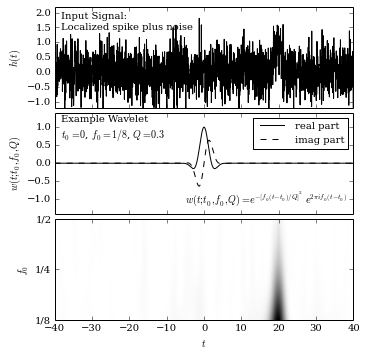

In [17]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import FT_continuous, IFT_continuous

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=False)


def wavelet(t, t0, f0, Q):
    return (np.exp(-(f0 / Q * (t - t0)) ** 2)
            * np.exp(2j * np.pi * f0 * (t - t0)))


def wavelet_FT(f, t0, f0, Q):
    # this is its fourier transform using
    # H(f) = integral[ h(t) exp(-2pi i f t) dt]
    return (np.sqrt(np.pi) * Q / f0
            * np.exp(-2j * np.pi * f * t0)
            * np.exp(-(np.pi * (f - f0) * Q / f0) ** 2))


def check_funcs(t0=1, f0=2, Q=3):
    t = np.linspace(-5, 5, 10000)
    h = wavelet(t, t0, f0, Q)

    f, H = FT_continuous(t, h)
    assert np.allclose(H, wavelet_FT(f, t0, f0, Q))

#------------------------------------------------------------
# Create the simulated dataset
np.random.seed(5)

t = np.linspace(-40, 40, 2001)[:-1]
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size=h.shape)

#------------------------------------------------------------
# Compute the convolution via the continuous Fourier transform
# This is more exact than using the discrete transform, because
# we have an analytic expression for the FT of the wavelet.
Q = 0.3
f0 = 2 ** np.linspace(-3, -1, 100)

f, H = FT_continuous(t, hN)
W = np.conj(wavelet_FT(f, 0, f0[:, None], Q))
t, HW = IFT_continuous(f, H * W)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0.05, left=0.12, right=0.95, bottom=0.08, top=0.95)

# First panel: the signal
ax = fig.add_subplot(311)
ax.plot(t, hN, '-k', lw=1)

ax.text(0.02, 0.95, ("Input Signal:\n"
                     "Localized spike plus noise"),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.2, 2.2)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel('$h(t)$')

# Second panel: the wavelet
ax = fig.add_subplot(312)
W = wavelet(t, 0, 0.125, Q)
ax.plot(t, W.real, '-k', label='real part', lw=1)
ax.plot(t, W.imag, '--k', label='imag part', lw=1)

ax.legend(loc=1)
ax.text(0.02, 0.95, ("Example Wavelet\n"
                     "$t_0 = 0$, $f_0=1/8$, $Q=0.3$"),
        ha='left', va='top', transform=ax.transAxes)
ax.text(0.98, 0.05,
        (r"$w(t; t_0, f_0, Q) = e^{-[f_0 (t - t_0) / Q]^2}"
         "e^{2 \pi i f_0 (t - t_0)}$"),
        ha='right', va='bottom', transform=ax.transAxes)

ax.set_xlim(-40, 40)
ax.set_ylim(-1.4, 1.4)
ax.set_ylabel('$w(t; t_0, f_0, Q)$')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# Third panel: the spectrogram
ax = fig.add_subplot(313)
ax.imshow(abs(HW) ** 2, origin='lower', aspect='auto', cmap=plt.cm.binary,
          extent=[t[0], t[-1], np.log2(f0)[0], np.log2(f0)[-1]])
ax.set_xlim(-40, 40)

ax.text(0.02, 0.95, ("Wavelet PSD"), color='w',
        ha='left', va='top', transform=ax.transAxes)

ax.set_ylim(np.log2(f0)[0], np.log2(f0)[-1])
ax.set_xlabel('$t$')
ax.set_ylabel('$f_0$')

ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, *args: ("1/%i"
                                                                 % (2 ** -x))))
plt.show()

## Digital Filtering

Digital filtering aims to reduce noise in time series data, or to compress data.  Common examples include low-pass filtering, where high frequencies are suppressed; high-pass filtering, where low frequencies are suppressed; passband filtering, where only a finite range of frequencies is admitted; and a notch filter, where a finite range of frequencies is blocked.  

It is important to note that filtering always decreases the information content of data, despite making it appear less noisy.  As we have already learned throughout previous chapters, when model parameters are stimated from data, raw (unfiltered) data should be used.  



### Low-pass Filters

The power spectrum for common Gaussian noise is flat and will extend to frequencies as high as the Nyquist limit, $f_N = 1/ (2\Delta t)$. If the data are band limited to a lower frequency, $f_c < f_N$, then they can be smoothed without much impact by suppressing frequencies $|f| > f_c$.  Given a filter in frequency space, $\Phi (f)$, we can obtain a smoothed version of data by taking the inverse Fourier transform of 

$$ \hat{Y}(f) = Y(f) \Phi(f), $$

where $Y(f)$ is the discrete Fourier transform of data.  At least in principle, we could simply set $\Phi(f)$ to zero for $|f| > f_c$, but this approach would result in unwanted oscillations in the signal.  Instead, the optimal filter for this purpose is constructed by minimising the MISE between $\hat{Y}(f)$ and $Y(f)$ and is called the Wiener filter:

$$ \Phi(f) = \frac{P_s(f)}{P_s(f)+P_N(f).}$$

Here, $P_s(f)$ and $P_N(f)$ represent signal and noise components of a fit to the PSD of input data, PSD$_Y(f) = P_s(f) + P_N(f)$, which holds as long as the signal and noise are uncorrelated.  


When data are not evenly sampled, the Wiener filter cannot be used.  There are numerous alternatives discussed in NumRec and digital signal processing literature.  As a low-pass filter, a very simple but powerful method is the Savitky-Golay filter, which fits low-order polynomials to data in the time domain using sliding windows.



### High-pass Filters

The most common example of high-pass filtering in astronomy is baseline estimation in spectral data.  Unlike the case of low-pass filtering, here there is no universal filter recipe.  

One simple iterative technique for high-pass filtering is called minimum component filtering, and the main steps include:
1. **Determine baseline:** exclude or mask regions where signal is clearly evident and fit a baseline model to the unmasked regions.
2. **Get FT for the signal:** after subtracting the baseline fit in the unmasked regions, apply the discrete Fourier transform.
3. **Filter the signal:** remove high frequencies usinga low-pass filter, and inverse Fourier transform the result.
4. **Recombine the baseline and filtered signal:** add the baseline fit subtracted in step 2 to the result from step 3.  This is the minimum component filtering estimate of baseline.



# Analysis of Periodic Time Series

Many systems have periodic signals - this is especially true in astronomy (e.g. RR-Lyrae, Cepheids, eclipsing binaries).  What we want to do is to detect variability and measure the period in the face of both noisy and incomplete data.  

For example, this figure is the kind of data that you want to have: 
<img src="ts_imgs/rrlyrae-good.png" style="width: 40%;"> 

Whereas this figure is the kind of data that you are more likely to have:
<img src="ts_imgs/rrlyrae-bad.png" style="width: 40%;">

A periodic time series satisfies $y(t+P) = y(t)$, where $P$ is the period.  In the context of periodic variability, a convenient conept is the so-called **phased light curve**, where the data (and models) are plotted as a function of phase,

$$ \phi = \frac{t}{P} - \text{int} \left ( \frac{t}{P} \right ),$$

where the function of int$(x)$ returns the integer part of $x$.

## A single Sinusoid Model

Given a time series data $(t_1, y_1), \ldots, (t_N, y_N)$, we want to test whether it is consistent with periodic variability, and if so, to estimate the period. In order to compute the posterior pdf for the frequency (or period) of a periodic variability in data, we need to adopt a specific model.

Let's consider a model based on a single harmonic with angular frequency $\omega$,

$$ y(t) = A \sin(\omega t + \phi) + \epsilon, $$

where the first term models the underlying process that generated the data and $\epsilon$ is the measurement noise.  Instead of using the phase $\phi$ it is possible to shif the time axis an dwrite the arguement as $\omega(t-t_0)$. 

We can use trig identities to rewrite this model as:

$$ y(t) = a \sin(\omega t) + b\cos(\omega t),$$

where $A=(a^2 + b^2)^{1/2}$ and $\phi = \tan^{-1}(b/a)$.  This model is now linear with respect to the coefficients $a$ and $b$, and nonlinear only with respect to frequency $\omega$. 

We fit this model to a set of data points $(t_j, y_j), \  j=1,\ldots,N$.  Note that there is no assumption that the times $t_j$ are evenly sampled.

Assuming constant uncertainties on the data, the liklihood for this model becomes

$$L \equiv p(\{t,y\}|w,a,b,\sigma) = \prod_{j=1}^N \frac{1}{\sqrt{2\pi} \sigma} \exp \left (  \frac{- [ y_j - a \sin(\omega t_j) - b \cos(\omega t_j)]^2}{2 \sigma^2}   \right )$$

where $y_j$ is the measurement taken at time $t_j$.  Assuming uniform priors on $a, b, \omega,$ and $\sigma$, which gives nonuniform priors on $A$ and $\phi$, the posterior pdf can be written as 

$$ p(\omega, a, b, \sigma| \{t,y\}) \propto \sigma^{-N} \exp \left ( \frac{-NQ}{2\sigma^2} \right ),$$

where 

$$ Q = V - \frac{2}{N} \left [ a I(\omega) + b R(\omega) - abM(\omega) - \frac{1}{2} a^2 S(\omega) - \frac{1}{2}b^2C(\omega) \right ].$$

The following terms depend only on data and frequency $\omega$:

$$ V = \frac{1}{N} \sum_{j=1}^N y_j^2$$

$$ I(\omega) = \sum_{j=1}^N y_j \sin(\omega t_j),\quad R(\omega) = \sum_{j=1}^N y_j \cos(\omega t_j)$$

$$ M(\omega) = \sum_{j=1}^N \sin(\omega t_j) \cos(\omega t_j)$$

$$ S(\omega) = \sum_{j=1}^N \sin^2(\omega t_j),\quad C(\omega) = \sum_{j=1}^N \cos^2(\omega t_j)$$

If $N >>1$, and we have data that extends longer than the period and has not been taken at special times, then $S(\omega) \approx C(\omega) \approx N/2$ and $M(\omega) << N/2$, and thus

$$ Q \approx V - \frac{2}{N} [ a I(\omega) + b R(\omega) + \frac{1}{2}(a^2+b^2).$$

When quantifying for the evidence for periodicity, we are not interested in specific values of $a$ and $b$, so we marginalize over those variables to derive

$$ p(\omega, \sigma | \{t,y\}) \propto \sigma^{-(N-2)}\exp \left ( \frac{-NV}{2\sigma^2} + \frac{P(\omega)}{\sigma^2} \right ),$$

where the periodogram is given by 

$$P(\omega) = \frac{1}{N} [ I^2(\omega) + R^2(\omega)].$$


In the case when the noise level $\sigma$ is known, the result further simplifies to 

$$ p(\omega| \{t,y\}, \sigma) \propto \exp \left ( \frac{P(\omega)}{\sigma^2} \right ).$$

Alternativly, when $\sigma$ is unkown, $p(\omega, \sigma | \{t,y\})$ can be marginalized over $\sigma$ to obtain

$$ p(\omega| \{t,y\}) \propto \left [ 1 - \frac{2P(\omega)}{NV} \right ] ^{1 - N/2}.$$

### The meaning of the periodogram

We have not yet answered what is the best value of $\omega$ supported by the data, and whether the implied periodic variability is statistically significant.  We can compute $\chi^2(\omega)$ for a fit with $a=a_0$ and $b=b_0$ as 

$$\chi^2(\omega) \equiv \frac{1}{\sigma^2} \sum_{j=1}^N [ y_j - y(t_j)]^2 = \frac{1}{\sigma^2} \sum_{j=1}^N [y_j - a_0\sin(\omega t_j) - b_0 \cos(\omega t_j) ]^2.$$

It can be shown that 

$$\chi^2(\omega) = \chi_0^2 \left [ 1 - \frac{2}{NV} P(\omega) \right ],$$

where $P(\omega)$ is the periodogram given above and $\chi_0$ corresponds to a model $y(t)=$ constant:

$$\chi_0^2 = \frac{1}{\sigma^2} \sum_{j=1}^N y_j^2 = \frac{NV}{\sigma^2}.$$

This result motivates a renormalized definition of the periodogram, defining the Lomb-Scargle periodogram as 

$$P_{LS}(\omega) = \frac{2}{NV}P(\omega).$$

With this renormalization, $0 \leq P_{LS}(\omega) \leq 1$.  

To determine if our source is variable or not, we first compute $P_{LS}(\omega)$ and then model the odds ratio for our variability model vs. a non-variable model. If the variability model is correct, then the peak of $P(\omega)$ gives the best $\omega$ and the $\chi^2$ at $\omega - \omega_0$ is $N$.  If the true frequency is $\omega_0$, then the maximum peak in the periodogram should have a height 

$$P(\omega_0) = \frac{N}{4}(a_0^2+b_0^2)$$

and standard deviation

$$\sigma_{P(\omega_0)} = \frac{\sqrt{2}}{2} \sigma^2.$$

Some important properites of periodograms:
- The expected height of the peaks in a periodogram does not depend on $\sigma$.  On the other hand, its variation from the expected height depends only on noise $\sigma$, and not on the sample size $N$.  
- The expected height of $P_{LS} = 1 - \sigma^2/V$  is bound in the 0-1 range.  As noise increases, $P_{LS}$ decreases and is "burried" in the background noise.
- To estimate the uncertainty on the peaks we can use a bootstrap approach.

### The significance of periodogram peaks

For a given $\omega$, the peak height is a measure of the reduction on $\chi^2$ achieved by the model, compared to $\chi^2$ for a no-variability pure noise model.  We can use BIC information criteria to compare these two models (see chapters 4 & 5).  

The difference in BIC is

$$ \Delta \text{BIC} = \chi_0^2 - \chi^2(\omega_0) - (k_0 - k_\omega) \ln N,$$

where the number of free parameters is $k_0 = 1$ for the no-variability model where the mean value was subtracted, and $k_\omega=4$ for a single harmonic model.  

For homoscedastic errors, 

$$ \Delta \text{BIC} = \frac{NV}{\sigma^2} P_{LS}(\omega_0) - 3 \ln N.$$

When errors are heteroscedastic, the term $NV/\sigma^2$ is replaced by $\chi_0^2 = \sum_j (y_j / \sigma_j)^2$.  

Therefore, to answer the question "Did my data come from a periodic process?" we need to compute $P_{LS}$ first, and then model odds ratio for a single sinusoid model vs. no-variability model via equations for $\Delta$BIC.  

## The Lomb-Scargle Periodogram

The Lomb-scargle periodogram is a standard model to search for periodicity in uneavenly sampled time series data.  A normalized Lomb-Scargle periodogram, with heteroscedastic errors, is defined as 

$$ P_{LS}(\omega) = \frac{1}{V} \left [ 
\frac{R^2(\omega)}{C(\omega)} + \frac{I^2(\omega)}{S(\omega)} \right ] ,$$

where the data-based quantities independent of $\omega$ are 

$$ \bar{y} = \sum_{j=1}^N w_j y_j, \quad \text{and} \quad V = \sum_{j=1}^N w_j(y_j - \bar{y})^2,$$

with weights (for homoscedastic errors $w_j = 1/N$)

$$ w_j = \frac{1}{W} \frac{1}{\sigma_j^2}, \quad W = \sum_{j=1}^N \frac{1}{\sigma_j^2}.$$

Quantities which depend on $\omega$ are defined as 

$$ R(\omega) = \sum_{j=1}^N w_j(y_j - \bar{y}) \cos[\omega (t_j - \tau)], \quad I(\omega) = \sum_{j=1}^N w_j (y_j - \bar{y}) \sin[\omega(t_j - \tau)], $$

$$ C(\omega) = \sum_{j=1}^N w_j(y_j - \bar{y}) \cos^2[\omega (t_j - \tau)], \quad S(\omega) = \sum_{j=1}^N w_j (y_j - \bar{y}) \sin^2[\omega(t_j - \tau)]. $$

The offset $\tau$ makes $P_{LS}$ invariant to translatiiosn of the $t$-axis, and is defined by 

$$ \tan(2 \omega \tau) = \frac{\sum_{j=1}^N w_j \sin(2 \omega t_j)}{\sum_{j=1}^N w_j \cos(2 \omega t_j)}.$$

### The Meaning of the Lomb-Scargle Periodogram

The close similarity of the Lomb-Scargle periodogram and the results obtained for a single harmonic model is evident. The main differences are inclusion of heteroscedastic (but still Gaussian) errors in the Lomb-Scargle periodogram and slightly different expressions for the periodograms.  The Lomb-Scargle periodogram actually corresponds to a single sinusoid model, and can be thought of as an "inverted" plot of the $\chi^2(\omega)$ normalized by the "no-variation" $\chi_0^2$.  The key point of using the periodogram is that the significance of each peak can be assesed.  

### Practical Applications of the Lomb-Scargle Periodogram

The underlying model of the Lomb-Scargle peridogram is nonlinear in frequency and basis functions at different frequencies are not orthogonal.  As a result, the periodogram has many local maxima, and thus in practice the global maximum of the periodogram is found by grid search.  The searched frequency range can be bounded by $\omega_{min} = 2 \pi / T_{data}$, where $T_{data}$ is the interval sampled by the data, and by $\omega_{max}$.  An appropriate choice of $\omega_{max}$ depends on the phase coverage at a given frequency and needs to be carefully chosen. 

The frequency step can be taken as proportional to $\omega_{min}$, $\Delta \omega = \eta \omega_{min}$, with $\eta \sim 0.1$. A linear regular grid for $\omega$ is a good choice because the width of peaks in $P_{LS}$ does not depend on $\omega_0$.  Note that in practice the ration $\omega_{max} / \omega_{min}$ can be very large and thus lead to many trial freqencies.  The use of trigonometric identities can speed up computations, as shown in the following example.  

### Example

Below is an example of a Lomb-Scargle periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t / P),$ with $P=0.3$.

http://www.astroml.org/gatspy/periodic/lomb_scargle.html gives more information on astroML's implementation.



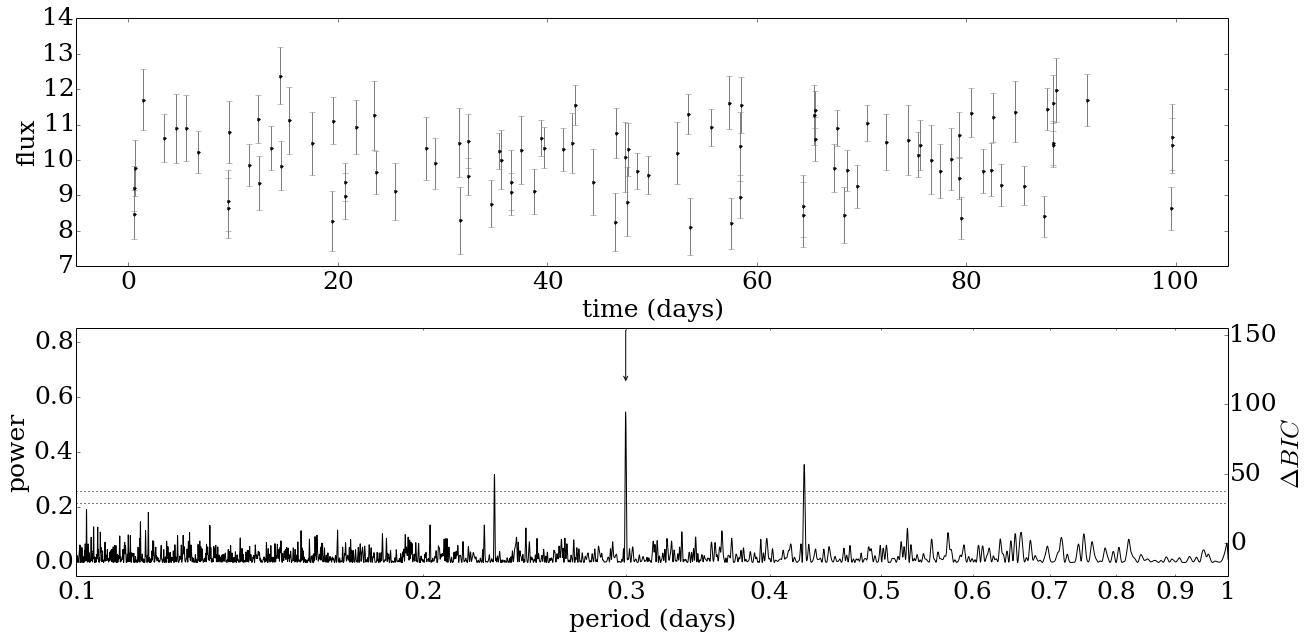

In [5]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 100
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=500, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])


#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

### False Alarm Probability

To find $\omega_0$ using data, $P_{LS}$ is evaluated for many different values of $\omega$ and thus the false alarm probability will reflect the multiple hypothesis testing discussed in chapter 4.  A starightforward method for computing the false alarm probability can by done with nonparametric bootstrap resampling wiht the times of obserations kept fixed and the values of $y$ drawn $B$ times from observed values with replacement.  The periodogram is computed for each resample and the maximum value found.  The distribution of $B$ maxima is then used to quantify the false alarm probability.  

### Generalized Lomb-Scargle

There is an important practical deficiency in the original Lomb-scargle method described above: it is implicitly assumed that the mean of the data values $\bar{y}$ is a good estimator of the mean of $y(t)$.  In practice, however, the data often do not sample all the phases equally, the data may be small, or it may not extend over the whole duration of a cycle, and the resulting error in mean can problems such as aliasing.  

A simple remedy is to add a constant offset term ot the model, and this analytic treatment has been dubbed the "generalized" Lomb-Scargle periodogram.  It has the form 

$$ y(t) = a\sin(\omega t) + b\cos(\omega t) + C$$

For example, consider the case of a star that has a period of one day and the fact that a single optical telescope only takes data at night.  In that case, we might get something like the top panel shown below (based on Figure 10.16 in the textbook - note the erratum!):

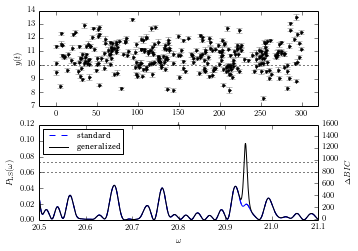

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#import numpy as np
#from matplotlib import pyplot as plt
#from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate data where y is positive
np.random.seed(0)
N = 30
P = 0.3

t = P / 2 * np.random.random(N) + P * np.random.randint(100, size=N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = y + np.random.normal(dy)

omega_0 = 2 * np.pi / P

#------------------------------------------------------------
# Generate data where y is positive
np.random.seed(0)
N = 300
P = 0.3

t = P / 2 * np.random.random(N) + P * np.random.randint(1000, size=N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.1 + 0.1 * np.random.random(N)
y_obs = y + np.random.normal(dy)

omega_0 = 2 * np.pi / P


#------------------------------------------------------------
# Compute the Lomb-Scargle Periodogram
sig = np.array([0.1, 0.01, 0.001])
omega = np.linspace(20.5, 21.1, 1000)

P_S = lomb_scargle(t, y_obs, dy, omega, generalized=False)
P_G = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))

# First panel: input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.plot([-20, 320], [10, 10], ':k', lw=1)

ax.set_xlim(-20, 320)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

# Second panel: periodogram
ax = fig.add_subplot(212)
ax.plot(omega, P_S, '--k', lw=1, label='standard', c='blue')
ax.plot(omega, P_S, '-', c='blue', lw=1)
ax.plot(omega, P_G, '-k', lw=1, label='generalized', c='black')
ax.legend(loc=2)

# plot the significance lines.
xlim = (omega[0], omega[-1])
ax.plot(xlim, [sig1, sig1], ':', c='black')
ax.plot(xlim, [sig5, sig5], ':', c='black')

# label BIC on the right side
ax2 = ax.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax.set_xlabel('$\omega$')
ax.set_ylabel(r'$P_{\rm LS}(\omega)$')
ax.set_xlim(xlim)
ax.set_ylim(0, 0.12)

plt.show()

# Where do we go from here?

If your time series data was sampled regularly, or can be modeled as a single sinusoid, great! That means we can use the methods described here today.  

If your data have an underlying variability that is more complex than a single sinusoid, is a stationary signal with an event localized in time, or is stocastically variable, we will have to use the methods described in the next lecture (the second half of chapter 10). 